# Data processing in Python - Final Project
# "Spatial Autocorrelation in Regional Covid Incidence 2020-2021"
### Heriberto Castilla, Jan Provazník

### DATA INTERPRETER
Our project does this 

## Import libraries and packages

In [147]:
import pandas as pd
import geopandas as gpd
import gdal
import shapely
import matplotlib.pyplot as plt
import descartes
import numpy as np
import pycountry
import esda
import libpysal as lps
import os
import gc
import imageio

## Define class

In [131]:
def get_country_code(name, nuts_id):
    country = pycountry.countries.get(alpha_2=name)
    if not country:
        country = nuts_id[:2]
    return country

def plot_color_map(shapefile, country_data, week, use_min_max=False):
    merged = shapefile.set_index('NUTS_ID').join(country_data)
    # create figure and axes for plot
    fig, ax = plt.subplots(1, figsize=(10, 6))
    if use_min_max:
        # set the min and max of the data so that the colors are consistent over time
        vmin, vmax = country_data.min().min(), country_data.max().max()
        # Plot the given week with the darker red representing more cases and lighter reds representing lower cases per region
        merged.plot(column=week, cmap='RdYlGn_r', linewidth=1.0, ax=ax, edgecolor='1.0', vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    else:
        merged.plot(column=week, cmap='RdYlGn_r', linewidth=1.0, ax=ax, edgecolor='1.0', legend=True)

class Country:

    def __init__(self, name, df):
        self.name = name
        # Pivot data so that the columns are the nuts_code while the rows are the covid cases
        nuts_code = df['nuts_code'].iloc[0]
        self.code = get_country_code(name, nuts_code)
        self.df = df.pivot(index='year_week', columns='nuts_code', values='rate_14_day_per_100k')
        self.shapefile = None
        # Pivot data so that index = nuts_code and columns = cases per year_week
        self.df_nuts_index = df.pivot(index='nuts_code', columns='year_week', values='rate_14_day_per_100k')

    def plot(self):
        self.df.plot()

    def set_shapefile(self, shapefile):
        self.shapefile = shapefile

    def plot_map(self):
        if self.shapefile:
            self.shapefile.plot(figsize=(14, 15))
            plt.show()

    # Inputs a week and plots a color map.
    def plot_country_color_map(self, week):
        country_data = self.df_nuts_index
        plot_color_map(self.shapefile, country_data, week)

## 1 Load data

In [132]:
# Data was downloaded from the following url https://opendata.ecdc.europa.eu/covid19/subnationalcaseweekly/csv
# Load the weekly data
weekly = pd.read_csv("covid_weekly_data.csv", sep=',').fillna(0)

# Load the daily data from downloaded file
daily = pd.read_csv("covid_daily_data.csv", sep=',').fillna(0)

In [133]:
weekly.head()
weekly['country'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden'], dtype=object)

In [134]:
daily.head()
daily['country'].unique()

array(['Austria', 'Denmark', 'Finland', 'Germany', 'Italy', 'Netherlands',
       'Portugal', 'Slovakia', 'Sweden', 'Belgium'], dtype=object)

## 2 Visualize data

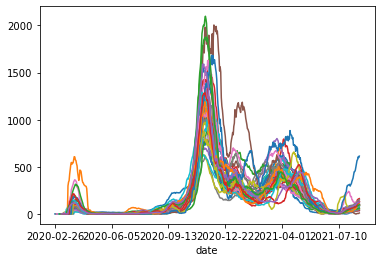

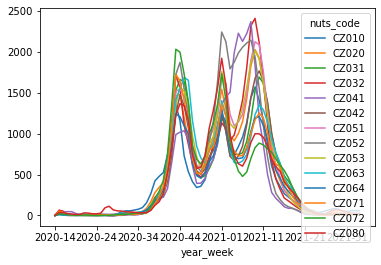

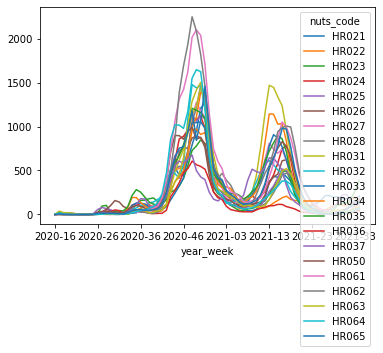

In [135]:
# Slice data from Austrian regions as an example
daily_au = daily.loc[daily['country'] == 'Austria']
daily_au = daily_au.pivot(index='date', columns='nuts_code', values='rate_14_day_per_100k')
daily_au.plot(legend=False)

# Slice data from Czech regions as an example
weekly_cz = weekly.loc[weekly['country'] == 'Czechia']
weekly_cz = weekly_cz.pivot(index='year_week', columns='nuts_code', values='rate_14_day_per_100k')
weekly_cz.plot()

# Pivot data so that index = nuts_code and columns = cases per year_week
nuts_code_index = weekly.pivot(index='nuts_code', columns='year_week', values='rate_14_day_per_100k')

# Create dictionary that maps from country code to Country() object
countries = {}

# Store all countries in weekly dataset with their own dataframe separately
for country in weekly['country'].unique():
    df = weekly.loc[weekly['country'] == country]
    country = Country(country, df)
    countries[country.code] = country

# As an example, plot Croatia's covid cases, with a line for each region
countries['HR'].plot()

## 3 Load shapefile

In [98]:
shapefile = gpd.read_file('NUTS3')

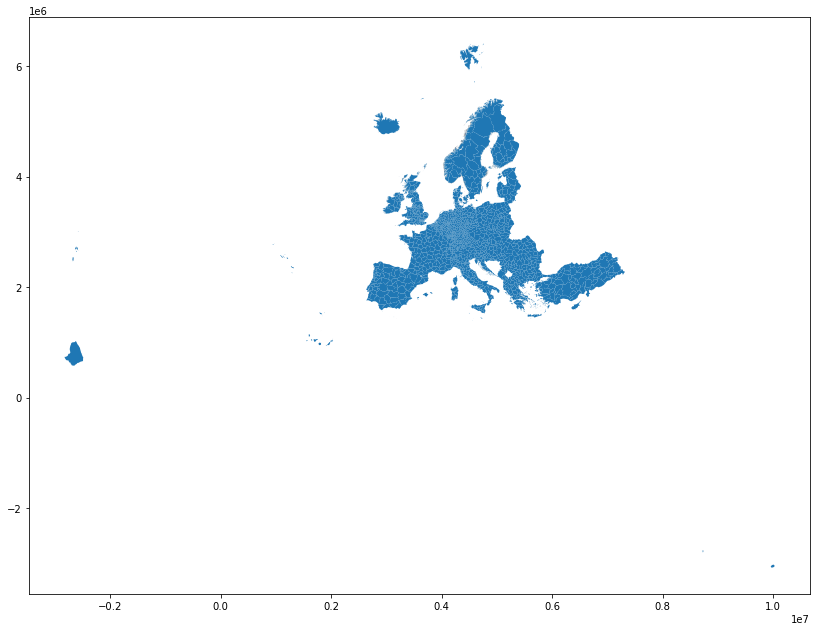

In [99]:
shapefile.plot(figsize=(14, 15))
plt.show()

In [14]:
print(shapefile.head())

  NUTS_ID  LEVL_CODE CNTR_CODE                    NAME_LATN  \
0   NO0B2          3        NO                     Svalbard   
1   NO0B1          3        NO         Jan Mayen\r\n   \r\n   
2   HR064          3        HR  Krapinsko-zagorska županija   
3   DE21A          3        DE                       Erding   
4   DE94E          3        DE         Osnabrück, Landkreis   

                     NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0                     Svalbard         3.0        3.0           1  NO0B2   
1         Jan Mayen\r\n   \r\n         NaN        NaN           1  NO0B1   
2  Krapinsko-zagorska županija         4.0        3.0           3  HR064   
3                       Erding         4.0        3.0           3  DE21A   
4         Osnabrück, Landkreis         4.0        2.0           3  DE94E   

                                            geometry  
0  MULTIPOLYGON (((4760536.161 6404487.632, 47607...  
1  POLYGON ((3673081.665 5420781.907, 3673257.365...  

In [15]:
shapefile["CNTR_CODE"].unique()

array(['NO', 'HR', 'DE', 'AL', 'BE', 'AT', 'ES', 'BG', 'FR', 'CZ', 'HU',
       'EL', 'FI', 'CH', 'CY', 'DK', 'EE', 'NL', 'IS', 'LV', 'MK', 'MT',
       'LT', 'IT', 'RS', 'PT', 'ME', 'PL', 'SE', 'IE', 'LU', 'RO', 'TR',
       'UK', 'LI', 'SK', 'SI'], dtype=object)

In [18]:
nuty_v_datech = [i for i in daily['nuts_code'].unique()]

In [19]:
vyber = [i for i in shapefile['NUTS_ID'].unique() if i in nuty_v_datech]

In [20]:
len(vyber)

622

In [45]:
daily.head()

,country,region_name,nuts_code,date,rate_14_day_per_100k,source
0,Austria,Mittelburgenland,AT111,2020-03-18,NaN,"TESSy COVID-19, subnational daily data"
1,Austria,Mittelburgenland,AT111,2020-03-19,NaN,"TESSy COVID-19, subnational daily data"
2,Austria,Mittelburgenland,AT111,2020-03-20,NaN,"TESSy COVID-19, subnational daily data"
3,Austria,Mittelburgenland,AT111,2020-03-21,NaN,"TESSy COVID-19, subnational daily data"
4,Austria,Mittelburgenland,AT111,2020-03-22,NaN,"TESSy COVID-19, subnational daily data"


In [70]:
daily['nuts_code'].unique()

array(['AT111', 'AT112', 'AT113', 'AT121', 'AT122', 'AT123', 'AT124',
       'AT125', 'AT126', 'AT127', 'AT130', 'AT211', 'AT212', 'AT213',
       'AT221', 'AT222', 'AT223', 'AT224', 'AT225', 'AT226', 'AT311',
       'AT312', 'AT313', 'AT314', 'AT315', 'AT321', 'AT322', 'AT323',
       'AT331', 'AT332', 'AT333', 'AT334', 'AT335', 'AT341', 'AT342',
       'DK011', 'DK012', 'DK013', 'DK014', 'DK021', 'DK022', 'DK031',
       'DK032', 'DK041', 'DK042', 'DK050', 'FI193', 'FI194', 'FI195',
       'FI196', 'FI197', 'FI1B1', 'FI1C1', 'FI1C2', 'FI1C3', 'FI1C4',
       'FI1C5', 'FI1D1', 'FI1D2', 'FI1D3', 'FI1D5', 'FI1D7', 'FI1D8',
       'FI1D9', 'FI200', 'DE111', 'DE112', 'DE113', 'DE114', 'DE115',
       'DE116', 'DE117', 'DE118', 'DE119', 'DE11A', 'DE11B', 'DE11C',
       'DE11D', 'DE121', 'DE122', 'DE123', 'DE124', 'DE125', 'DE126',
       'DE127', 'DE128', 'DE129', 'DE12A', 'DE12B', 'DE12C', 'DE131',
       'DE132', 'DE133', 'DE134', 'DE135', 'DE136', 'DE137', 'DE138',
       'DE139', 'DE1

In [33]:
shapefile['NUTS_ID'].unique()

array(['NO0B2', 'NO0B1', 'HR064', ..., 'UKM76', 'UKM78', 'UKK24'],
      dtype=object)

In [31]:
codes = ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'LV', 'LI', 'LT', 'LU', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE']

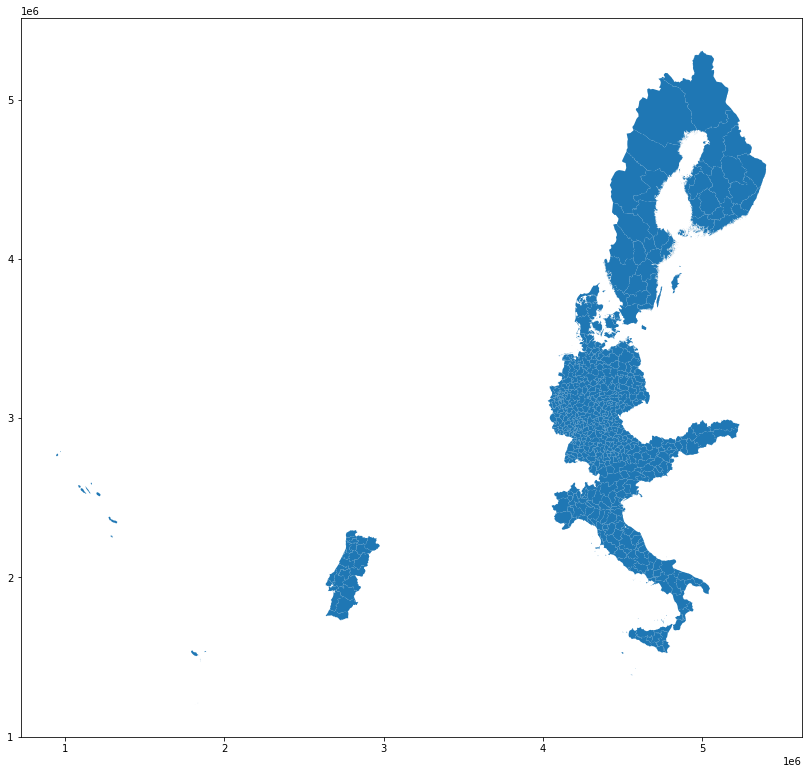

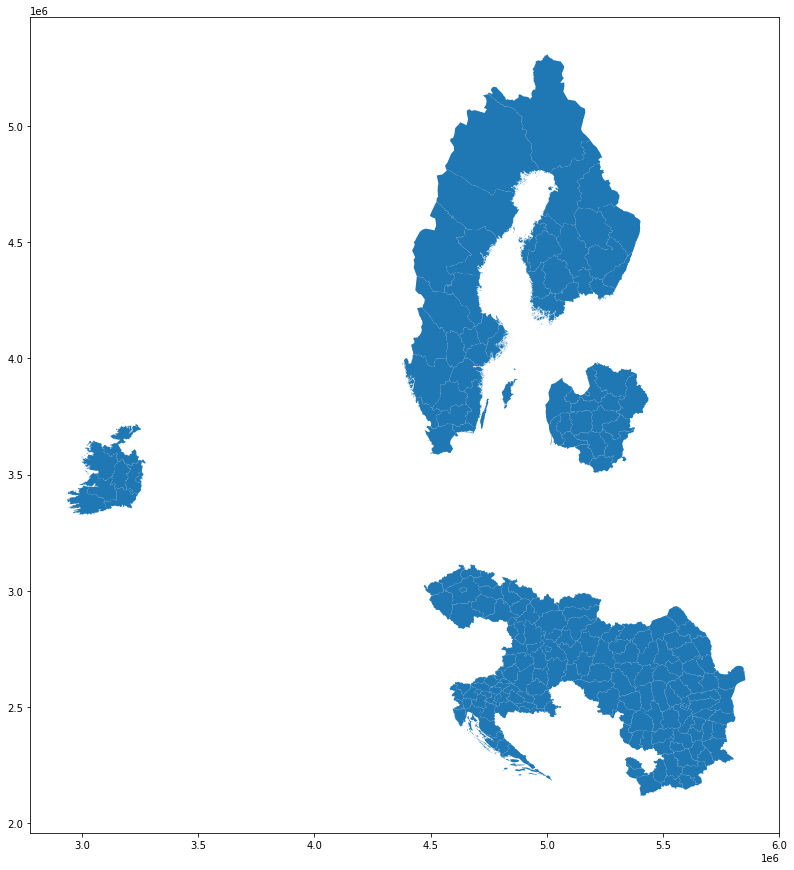

In [14]:
vyber = shapefile[shapefile['FID'].isin(daily['nuts_code'].unique())]
vyber.plot(figsize=(14, 15))
plt.show()
vyber_weekly = shapefile[shapefile['FID'].isin(weekly['nuts_code'].unique())]
vyber_weekly.plot(figsize=(14, 15))
plt.show()

In [78]:
# Show any countries that are in the shapefile that are missing from the csv data when matching on country code
print("Print any countries that are missing from the csv data matching on country code")
print(set(shapefile["CNTR_CODE"].unique()) - set([country for country in countries]))

# Show countries that are in the shapefile that are missing from the csv data when matching on nuts_id
print("\n Print countries that are in the shapefile that are missing from the csv data when matching on nuts_id")
print(set(shapefile["CNTR_CODE"]) - set(vyber_weekly["CNTR_CODE"]))
print(set(shapefile["CNTR_CODE"]) - set(vyber["CNTR_CODE"]))

Print any countries that are missing from the csv data matching on country code
{'AL', 'RS', 'ME', 'UK', 'TR', 'CH', 'MK'}

 Print countries that are in the shapefile that are missing from the csv data when matching on nuts_id
{'LU', 'RS', 'ME', 'NO', 'DE', 'EL', 'TR', 'MK', 'IS', 'MT', 'PT', 'DK', 'UK', 'BE', 'EE', 'NL', 'CY', 'AT', 'AL', 'CH', 'ES', 'IT', 'FR', 'PL', 'LI'}
{'LU', 'RS', 'NO', 'ME', 'EL', 'TR', 'MK', 'IS', 'BG', 'MT', 'CZ', 'IE', 'UK', 'LT', 'BE', 'EE', 'NL', 'HU', 'AL', 'CY', 'CH', 'ES', 'RO', 'HR', 'LV', 'SI', 'FR', 'PL', 'LI'}


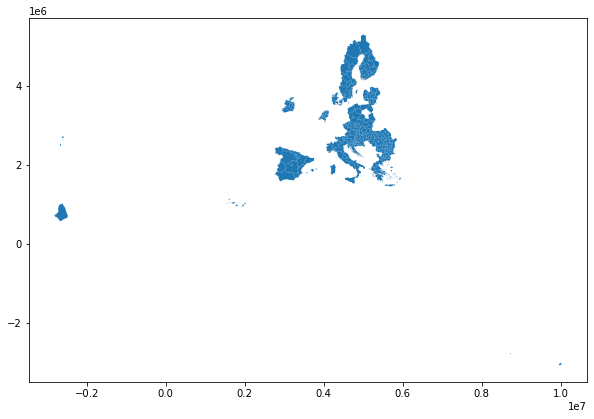

In [128]:
# It is possible that the nuts_id in the covid data is actually a mixture of NUTS2 AND NUTS3 codes, so we can merge both shapefiles and find what countries can match up.
shapefile_nuts2 = gpd.read_file('NUTS2')

# Use both NUTS2 and NUTS3 data to match with the weekly covid case data
merged_sf = shapefile.append(shapefile_nuts2)
data_map = merged_sf[merged_sf['NUTS_ID'].isin(weekly['nuts_code'].unique())]
data_map.plot(figsize=(10,10))
plt.show()

Even when merging NUTS2 and NUTS3 shapefiles, the covid data both for weekly and daily cases has nuts codes that do not match up with the NUTS_ID in the shapefiles. This can be concluded because the covid data does include the countries missing in the maps, so there must be a mismatch between the nuts codes. Due to this we choose a few countries on which to do analysis. 4 countries that we have complete NUTS3 data for and that are adjacent could be: Hungary, Croatia, Czechia and Slovakia (HU, HR, CZ, SK).

### Visualize country covid cases over time using the shapefile

In [136]:
# For all countries in covid dataset store their shapefiles as well
for country in countries.values():
    sf = shapefile.loc[shapefile['CNTR_CODE'] == country.code]
    country.set_shapefile(sf)

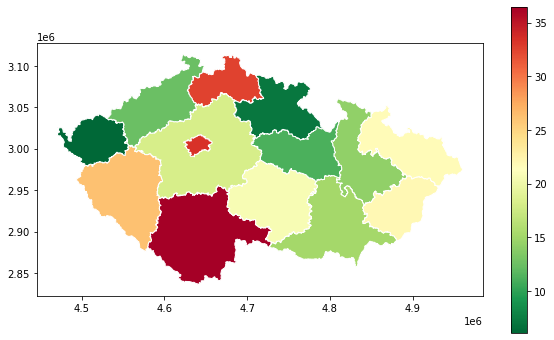

In [137]:
# Plot CZ as an example
countries['CZ'].plot_country_color_map('2021-24')

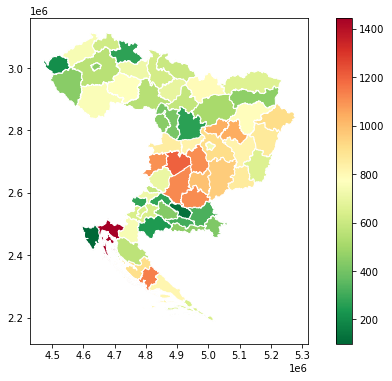

In [138]:
# Plot Hungary, Croatia, Czechia and Slovakia
countries_to_plot = ['CZ', 'HU', 'HR', 'SK']
country_shapefile = shapefile.loc[shapefile['CNTR_CODE'].isin(countries_to_plot)]

country_data = pd.DataFrame()
for c in countries_to_plot:
    df = countries[c].df_nuts_index
    country_data = country_data.append(df)

week = '2021-14'
plot_color_map(country_shapefile, country_data, week)

In [144]:
# save all the maps in a folder called maps
output_path = 'maps'
filenames = []
country_obj = countries['CZ']
merged = country_obj.shapefile.set_index('NUTS_ID').join(country_obj.df_nuts_index)
# set the min and max of the data so that the colors are consistent over time
vmin, vmax = country_data.min().min(), country_data.max().max()

# create one map per week for Czechia as an example
for week in countries['CZ'].df.index:
    # create map and add plt.Normalize to keep the legend range the same for all maps
    fig = merged.plot(column=week, cmap='RdYlGn_r', linewidth=1.0, edgecolor='1.0', vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    plt.title("Covid rate_14_day_per_100k in the year-week: " + week)
    # remove axis of chart
    fig.axis('off')
    # Save figure in the output path
    filepath = os.path.join(output_path, week + '_covid_cases.jpg')
    filenames.append(filepath)
    fig.get_figure().savefig(filepath, dpi=300)
    # clear the figure to save memory
    plt.close()
    gc.collect()

In [151]:
# Create a gif with the images saved above
with imageio.get_writer('colormap.gif', mode='I', fps=3) as writer:
    for fn in filenames:
        colormap = imageio.imread(fn)
        writer.append_data(colormap)

![ColorMap](colormap.gif "colormap")

## 4 Generate weight matrix

## 5 Calculate Moran's I from the data and the matrix

## 6 Visualize Moran's I time series

Here we will visualize the Moran's I time series in a plot. We don't have the series yet, so let's generate a random one for now and visualize it and then at the end, when the series is finally obtained, we will just substitute it in the plot.

In [11]:
import numpy as np
import pandas as pd

# Generate a random time series y
y = [0]*400
for i in range(1,400):
    y[i] = 0.5*y[i-1] + np.random.normal(loc=0.0, scale=1.0, size=None)
y = pd.DataFrame(y)

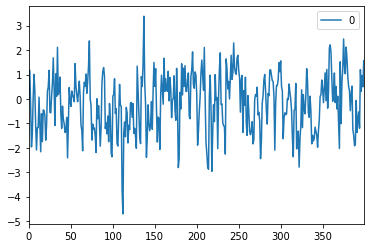

In [14]:
#make a plot of y:
y.plot()